In [9]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from glob import glob
from PIL import Image
import numpy as np

In [2]:
data_dir = r"C:\Users\HP\OneDrive\Documents\Project\Project 5\Solar Panel"

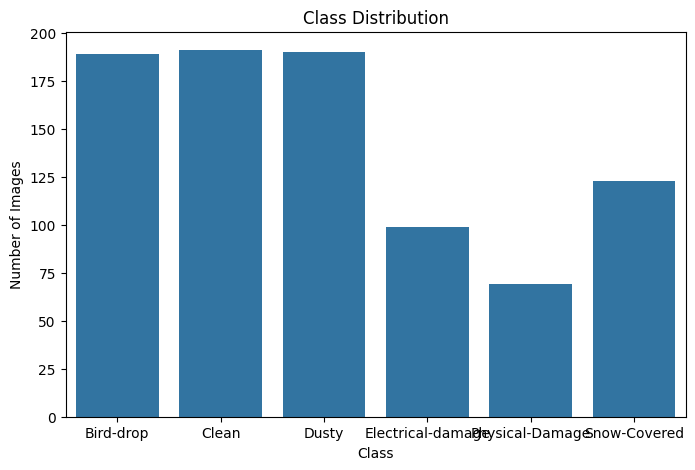

In [3]:
classes = os.listdir(data_dir)
img_paths = {cls: glob(os.path.join(data_dir, cls, "*.jpg")) for cls in classes}


# Count images per class
class_counts = {cls: len(imgs) for cls, imgs in img_paths.items()}


plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

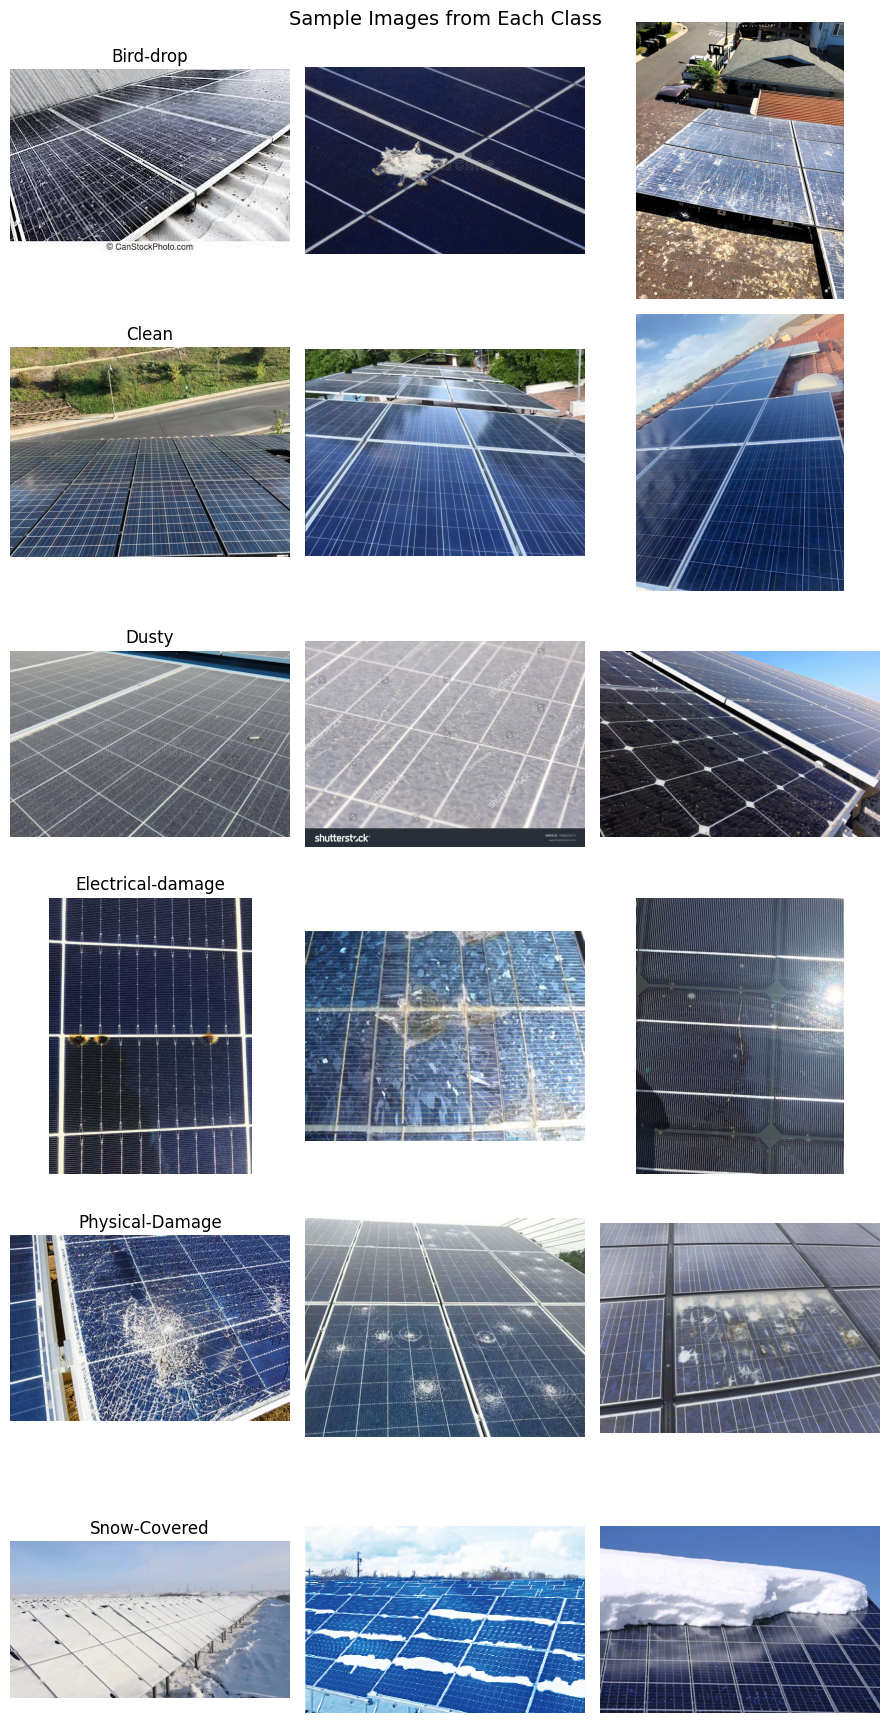

In [5]:
n_samples = 3
fig, axes = plt.subplots(len(classes), n_samples, figsize=(n_samples*3, len(classes)*3))


for i, cls in enumerate(classes):
 samples = random.sample(img_paths[cls], min(n_samples, len(img_paths[cls])))
 for j, img_path in enumerate(samples):
  img = Image.open(img_path)
  axes[i, j].imshow(img)
  axes[i, j].axis("off")
  if j == 0:
   axes[i, j].set_title(cls)


plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

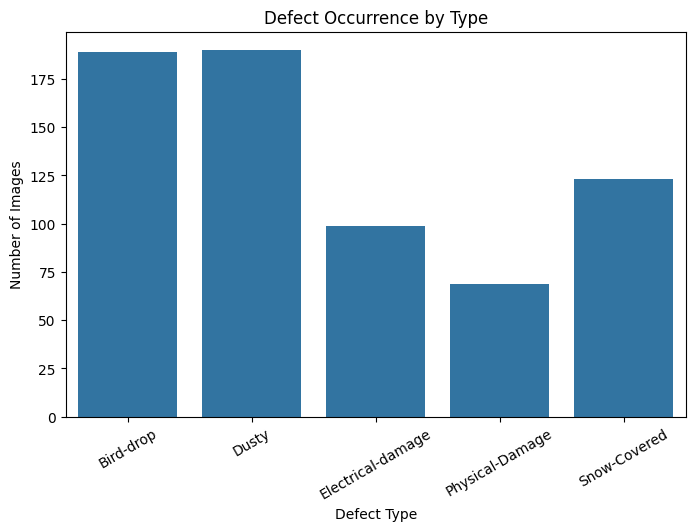

In [7]:
defect_classes = [
    'Bird-drop',
    'Dusty',
    'Electrical-damage',
    'Physical-Damage',
    'Snow-Covered'
]

# Count occurrences from class_counts
defect_counts = Counter({cls: class_counts.get(cls, 0) for cls in defect_classes})

# Plot defect occurrence
plt.figure(figsize=(8,5))
sns.barplot(x=list(defect_counts.keys()), y=list(defect_counts.values()))
plt.title("Defect Occurrence by Type")
plt.ylabel("Number of Images")
plt.xlabel("Defect Type")
plt.xticks(rotation=30)
plt.show()

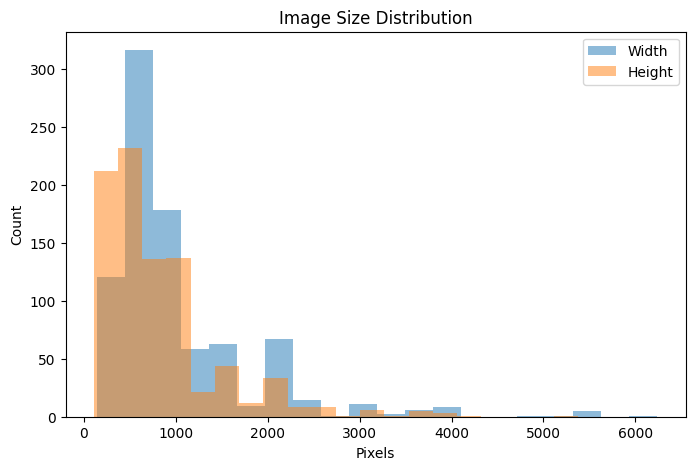

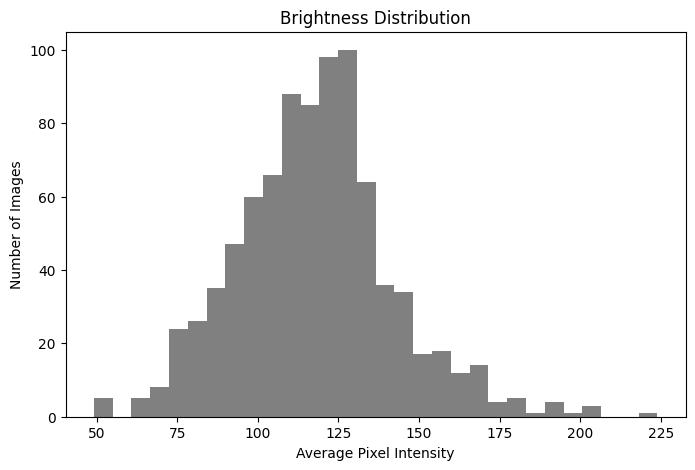

In [11]:
all_sizes = []
brightness_values = []


for cls, paths in img_paths.items():
 for path in paths:
  img = Image.open(path).convert("RGB")
  all_sizes.append(img.size)
  arr = np.array(img)
  brightness_values.append(arr.mean())


# Image size distribution
widths, heights = zip(*all_sizes)
plt.figure(figsize=(8,5))
plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.legend()
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

# Brightness distribution
plt.figure(figsize=(8,5))
plt.hist(brightness_values, bins=30, color='gray')
plt.title("Brightness Distribution")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Number of Images")
plt.show()

In [12]:
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / (min_count if min_count > 0 else 1)
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

Class imbalance ratio (max/min): 2.77


In [13]:
total_images = sum(class_counts.values())
rare_threshold = 0.1 * total_images # classes with <10% of samples flagged
rare_defects = {cls: count for cls, count in class_counts.items() if count < rare_threshold}


if rare_defects:
 print("⚠️ Rare defect classes detected:")
 for cls, count in rare_defects.items():
  print(f" - {cls}: {count} samples ({count/total_images*100:.2f}% of dataset)")
else:
 print("No rare defect classes detected.")

⚠️ Rare defect classes detected:
 - Physical-Damage: 69 samples (8.01% of dataset)


Image: C:\Users\HP\OneDrive\Documents\Project\Project 5\test_images\sample.jpeg
Classification: Dusty

image 1/1 C:\Users\HP\OneDrive\Documents\Project\Project 5\test_images\sample.jpeg: 416x416 1 Clean, 643.8ms
Speed: 36.0ms preprocess, 643.8ms inference, 25.3ms postprocess per image at shape (1, 3, 416, 416)


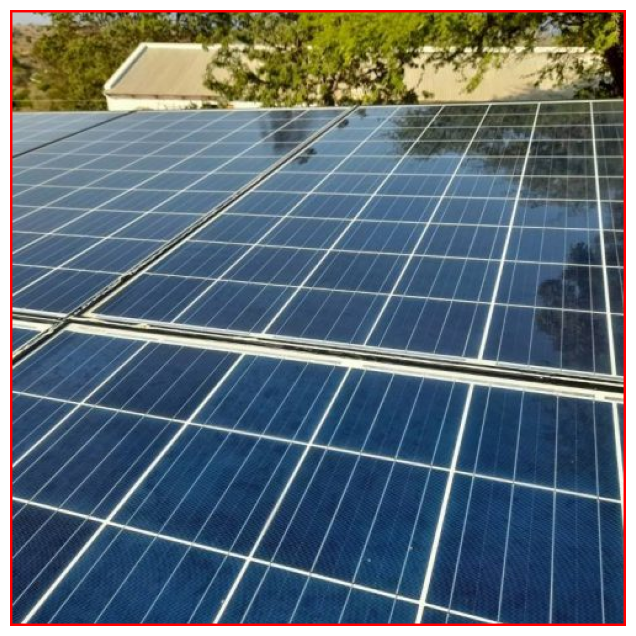

<Figure size 800x600 with 0 Axes>

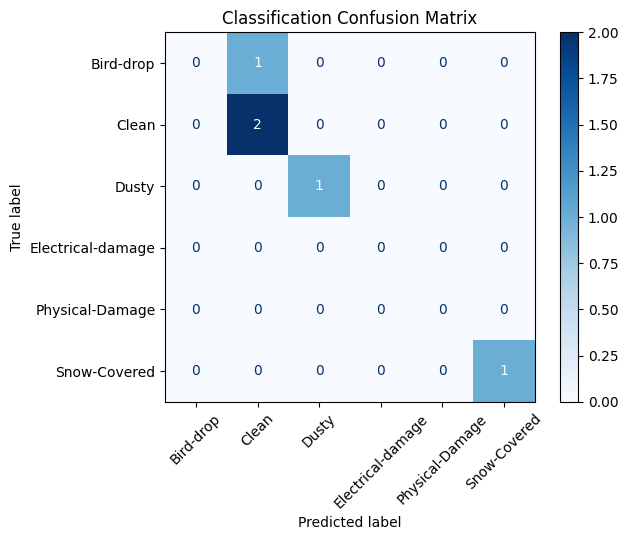

,Defect Type,Occurrence,Suggested Action
0,Bird-drop,45,Install deterrents
1,Clean,100,No action
2,Dusty,120,Schedule cleaning weekly
3,Electrical-damage,5,Immediate inspection & repair
4,Physical-Damage,8,Check panel integrity
5,Snow-Covered,30,Seasonal clearing


In [18]:
# ===============================
# Step 1: Import Libraries
# ===============================
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import pandas as pd
from ultralytics import YOLO

# ===============================
# Step 2: Load Classification Model
# ===============================
num_classes = 6
class_names = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

model_class = models.mobilenet_v2(weights=None)
model_class.classifier[1] = torch.nn.Linear(model_class.last_channel, num_classes)
model_class.load_state_dict(torch.load("MobileNet.pth", map_location='cpu'))
model_class.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ===============================
# Step 3: Classification Function
# ===============================
def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model_class(img_tensor)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

# ===============================
# Step 4: Load YOLO Model
# ===============================
model_yolo = YOLO("best.pt")  # YOLOv8 model for obstructions

# ===============================
# Step 5: Obstruction Detection Function
# ===============================
def detect_obstructions(image_path):
    results = model_yolo(image_path)
    img = cv2.imread(image_path)
    
    for box, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, f"{model_yolo.names[int(cls)]}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# ===============================
# Step 6: Confusion Matrix Function
# ===============================
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Classification Confusion Matrix")
    plt.show()

# ===============================
# Step 7: Defect Summary Table
# ===============================
def generate_defect_table(defect_counts):
    df = pd.DataFrame(list(defect_counts.items()), columns=['Defect Type', 'Occurrence'])
    df['Suggested Action'] = [
        'Install deterrents', 'No action', 'Schedule cleaning weekly',
        'Immediate inspection & repair', 'Check panel integrity', 'Seasonal clearing'
    ]
    return df

# ===============================
# Step 8: Sample Images Analysis
# ===============================
sample_folder = r"C:\Users\HP\OneDrive\Documents\Project\Project 5\test_images"
image_extensions = ['.jpg', '.jpeg', '.png']

# Get all image file paths
sample_images = [os.path.join(sample_folder, f) for f in os.listdir(sample_folder)
                 if os.path.splitext(f)[1].lower() in image_extensions]

# Analyze images
for img_path in sample_images:
    print(f"Image: {img_path}")
    
    # Classification
    cls_result = classify_image(img_path)
    print("Classification:", cls_result)
    
    # Obstruction Detection
    detect_obstructions(img_path)

# ===============================
# Step 9: Example Confusion Matrix
# ===============================
y_true = ['Clean', 'Dusty', 'Bird-drop', 'Clean', 'Snow-Covered']
y_pred = ['Clean', 'Dusty', 'Clean', 'Clean', 'Snow-Covered']

plot_confusion_matrix(y_true, y_pred)

# ===============================
# Step 10: Example Defect Table
# ===============================
defect_counts = {
    'Bird-drop': 45,
    'Clean': 100,
    'Dusty': 120,
    'Electrical-damage': 5,
    'Physical-Damage': 8,
    'Snow-Covered': 30
}

df_defects = generate_defect_table(defect_counts)
df_defects
